## Importujemy potrzebne biblioteki

In [57]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# nltk
import nltk
nltk.download("stopwords")

# help
import numpy as np
import pandas as pd
import json
import glob

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

# spacy
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from nltk.corpus import stopwords
spacy.load("en_core_web_sm")

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Definiujemy funkcje 

In [36]:
def head(data, n=5):
    for i in range(n):
        print(data[i])

In [37]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]): # Part Of Speech TAGS
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        texts_out.append(" ".join(new_text))
#         print("|", end="")
    return texts_out

In [38]:
def stemming(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]): # Part Of Speech TAGS
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.text) # change
        texts_out.append(" ".join(new_text))
#         print("|", end="")
    
    porter_stem = gensim.parsing.porter.PorterStemmer() # change
    texts_out = porter_stem.stem_documents(texts_out) # change
    return texts_out

In [39]:
def preprocess(texts):
    return [gensim.utils.simple_preprocess(text, deacc=True) for text in texts]

In [40]:
def remove_cssw_low(bow, p_up=1, p_down=0, percentile=0.4, occ_up=None, occ_down=0): 
    """
    cssw - corpus_specific_stop_words
    low  - low_occurence_words
    """
    n = len(bow)
    bow_frec = defaultdict(int)
    for doc in bow:
        for key, am in doc:
            bow_frec[key] += am
    bow_frec = list(bow_frec.items())
    
    doc_occ = defaultdict(int)
    for doc in bow:
        for key, _ in doc:
            doc_occ[key] += 1
    
    dd = [(key, am, doc_occ[key] / n) for key, am in bow_frec]
    
    if not occ_up:
        dd.sort(key=lambda x: x[1], reverse=True)
        occ_up = dd[0][1]

    most_occ_words = int(len(dd) * (1-percentile))
    dd = dd[:most_occ_words]

    dd_cleaned = [
        (key, am, occ)
        for key, am, occ in dd
        if (p_down < round(occ,3) <= p_up)# and (occ_down <= am <= occ_up)
    ]
    
    return dd_cleaned, abs(len(dd_cleaned) - len(dd))

In [41]:
def perplexity_score(params, corpus, dictionary):
    lda_model = LdaModel(corpus=corpus, id2word=id2word, **params)
    perplexity = lda_model.log_perplexity(corpus)
    return -perplexity  # Minimize negative perplexity

In [88]:
def prepare_topic_dist_for_plot(lda_model, corpus):
    topic_dist = [
        lda_model[corpus[i]]
        for i in range(len(corpus))
    ]
    
    topic_dist_list = []
    for doc in topic_dist:
        topic_dist_list.append([doc[i-1][1] for i in range(lda_model.num_topics)])

    td = np.array(topic_dist_list)
    return td

In [43]:
def most_repr_docs_for_topics(lda_model, topic_dist_array, data):  
    n_topics = topic_dist_array.shape[1]
    repr_docs = np.argmax(topic_dist_array, axis=0)
    
    keywords = [
        ", ".join(list(map(lambda x: x[0], lda_model.show_topic(i, topn=5))))
        for i in range(n_topics)
    ]
    
    texts = [
        data[repr_docs[i]]
        for i in range(n_topics)
    ]
    
    pct_topics = [
        topic_dist_array[repr_docs[i]][i]
        for i in range(n_topics)
    ]
    
    df = pd.DataFrame({
        "Topic": range(n_topics),
        "Keywords": keywords,
        "Text": texts,
        "Topic_pct": pct_topics
    })
    df = df.set_index("Topic", drop=True)
    
    return df

In [44]:
def get_metrics(lda_model, corpus, data_words, id2word, _print=True):
    """
    returns Coherence, Perplexity
    """
    coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    perplexity_score = lda_model.log_perplexity(corpus)
    
    if _print:
        print("Coherence:  ", coherence_score)
        print("Perplexity:", perplexity_score)
    return coherence_score, perplexity_score

In [45]:
def sample_Dir3d(alpha, size):
    return np.random.dirichlet(alpha, size)

In [46]:
def visualize_3d(topic_dist, sec_ds=None, c='b', marker='o', s=3, alpha=0.5, show=True, c2='g', marker2='o', s2=3, alpha2=0.5):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=45, azim=45)
    
    ax.scatter(topic_dist[:, 0], topic_dist[:, 1], topic_dist[:, 2], c=c, marker=marker, s=s, alpha=alpha, zorder=5)
    
    if sec_ds is not None:
        ax.scatter(sec_ds[:, 0], sec_ds[:, 1], sec_ds[:, 2], c=c2, marker=marker2, s=s2, alpha=alpha2, zorder=5)

    # plot mean
    sample_mean = topic_dist.mean(axis=0)
    ax.scatter(sample_mean[0], sample_mean[1], sample_mean[2], s=200, alpha=1, c="red")

    # plot triangle
    x_points = [1,  0,  0]
    y_points = [0,  1,  0]
    z_points = [0,  0,  1]
    ax.scatter(x_points, y_points, z_points, c="r", marker='o', s=10, alpha=1)

    ax.plot([0, 1], [1, 0], [0, 0], c="r", linewidth=1)
    ax.plot([0, 0], [1, 0], [0, 1], c="r", linewidth=1)
    ax.plot([1, 0], [0, 0], [0, 1], c="r", linewidth=1)
    
    ax.text(1+0.05, 0, 0, "X=1")
    ax.text(0, 1, -0.05, "Y=1")
    ax.text(0, 0, 1+0.02, "Z=1")

    ax.set_xlabel('X', fontsize=13)
    ax.set_ylabel('Y', fontsize=13)
    ax.set_zlabel('Z', fontsize=13)
    
    fig.set_facecolor("white")

    if show:
        plt.show()

In [47]:
def create_save_vis(lda_model, corpus, id2word, filename="lda.html"):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=20)
    
    pyLDAvis.save_html(vis, filename)
    return vis

## Lista funkcji wraz z opisami
* ```head``` - wyświetla pierwsze n rekordów z listy,
* ```lemmatization``` - lematyzacja,
* ```stemming``` - stemming (algorytm Portera),
* ```preprocess``` - konwertuje korpus na listę tokenów,
* ```remove_cssw_low``` - usuwa "specyficzne dla korpusu słowa stop" (corpus-specific stop words) oraz "słowa o niskiej częstości występowania" (low-occurence words),
* ```perplexity_score``` - nieużywane,
* ```prepare_topic_dist_for_plot``` - zwraca rozkład tematów we wszystkich dokumentach,
* ```most_repr_doc_for_topic``` - zwraca DataFrame z najbardziej reprezentatywnymi dokumentami dla tematów,
* ```get_metrics``` - zwraca współczynniki coherence & perplexity,
* ```sample_Dir3d``` - generuje próbkę danych z rozkładu Dirichleta,
* ```visualize_3d``` - wykreśla punkty danych na trójkącie $(x+y+z=1; x,y,z > 0)$,
* ```create_save_vis``` - tworzy i zapisuje (domyślnie jako html) obiekt pyLDAvis.

## Pobieramy dane
jest to tabela danych z tweetami (```text```), wraz z miejscem ich napisania (```location```), słowami klucz (```keyword```), oraz etykietą mówiącą czy dany tweet opisuje katastrofę, wojnę lub atak terrorystyczny (1), czy też nie (0) (```target```).

In [48]:
df_orig = pd.read_csv(r'data\Dataset.csv')
df_orig.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
print("Ilość tweetów:", df_orig.shape[0])

Ilość tweetów: 7613


In [50]:
print("Braki w kolumnach 'keyword', 'location':")
print(f"{df_orig.keyword.isna().sum()}, {df_orig.location.isna().sum()}")

Braki w kolumnach 'keyword', 'location':
61, 2533


In [51]:
df_orig.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [52]:
df_orig.keyword.value_counts()#.value_counts().sort_index()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

Po krótkiej analizie innych kolumn, doszliśmy do wniosku, że ze względu na duże braki w danych i zbyt dużą liczbę unikatowych wartości w kolumnach kategorycznych ograniczymy naszą analizę do kolumny ```text```.

In [53]:
data = df_orig["text"].tolist()
len(data)

7613

In [54]:
head(data)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


## Lematyzacja & Stemming
Stosujemy algorytmy lematyzacji i stemmingu oraz przedstawiamy po kilka wyników tych metod.

In [58]:
lemmatized_texts = lemmatization(data)

In [59]:
head(lemmatized_texts)

deed earthquake forgive
forest fire
resident ask shelter place notify officer other evacuation shelter place order expect
people receive wildfire evacuation order
just get send photo # smoke wildfire pour school


In [60]:
stemmed_texts = stemming(data)

In [61]:
head(stemmed_texts)

deed earthquak forgiv
forest fire
resid ask shelter place notifi offic other evacu shelter place order expect
peopl receiv wildfir evacu order
just got sent photo # smoke wildfir pour school


# Wybieramy metodę normalizacji
Wybraliśmy lematyzację

In [62]:
lem = True
if lem:
    chosen_data = lemmatized_texts
else:
    chosen_data = stemmed_texts

## Preprocessing
Usuwamy akcent na słowach, usuwamy znaki specjalne, zamieniamy tekst na listę słów.

In [63]:
data_words = preprocess(chosen_data)

In [64]:
head(data_words)

['deed', 'earthquake', 'forgive']
['forest', 'fire']
['resident', 'ask', 'shelter', 'place', 'notify', 'officer', 'other', 'evacuation', 'shelter', 'place', 'order', 'expect']
['people', 'receive', 'wildfire', 'evacuation', 'order']
['just', 'get', 'send', 'photo', 'smoke', 'wildfire', 'pour', 'school']


## Id2word
Zamieniamy dane na "Bag of Words" (BoW). Zamienia on uporządkowaną listę słów na listę id odpowiednich dla poszczególnych słów oraz liczbę ich wystąpień w tekście, w BoW kolejność słów nie ma znaczenia.

In [65]:
id2word = corpora.Dictionary(data_words)
len(id2word)

11431

In [66]:
bow = [
    id2word.doc2bow(text)
    for text in data_words
]
head(bow)

[(0, 1), (1, 1), (2, 1)]
[(3, 1), (4, 1)]
[(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2)]
[(6, 1), (10, 1), (15, 1), (16, 1), (17, 1)]
[(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


## corpus_specific_stop_words & low_occurence_words
Usuwamy "corpus specific stop words" i "low occurence words".

In [67]:
data_cleaned, removed = remove_cssw_low(bow, p_up=0.2, )# occ_down=10)
removed, len(data_cleaned)

(4886, 1972)

In [68]:
data_cleaned.sort(key=lambda x: x[2], reverse=True)
head(data_cleaned)

(18, 407, 0.050834099566530934)
(19, 322, 0.040982529883094705)
(240, 316, 0.04006305004597399)
(3, 298, 0.03651648495993695)
(51, 274, 0.03336398266123736)


In [69]:
keys_bow = [key for key, am, p in data_cleaned]
keys_bow[:10], len(keys_bow)

([18, 19, 240, 3, 51, 109, 44, 450, 15, 38], 1972)

In [70]:
corpus = [
    [(key, value) for key, value in doc if (key in keys_bow)]
    for doc in bow
]
head(corpus)

[(1, 1), (2, 1)]
[(3, 1), (4, 1)]
[(5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2)]
[(6, 1), (10, 1), (15, 1), (16, 1), (17, 1)]
[(17, 1), (18, 1), (19, 1), (20, 1), (22, 1), (23, 1), (24, 1)]


#### Wyszukujemy puste dokumenty

In [71]:
empty_docs = [
    i 
    for i in range(len(corpus))
    if len(corpus[i]) == 0
]
print(empty_docs[:5])
print(len(empty_docs))

[19, 24, 28, 37, 43]
263


lematyzacja wyrzuca wszystkie linki

In [72]:
ind = empty_docs[0]
print(ind)
print(data[ind])
print(chosen_data[ind])
print(data_words[ind])
print(corpus[ind])

19
What a goooooooaaaaaal!!!!!!
goooooooaaaaaal
['goooooooaaaaaal']
[]


## Tworzymy obiekt LDA

In [73]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
#     random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto"
)

## Wizualizacja

In [74]:
create_save_vis(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.202153  0.242660       1        1  27.769935
4     -0.007260 -0.302382       2        1  22.310396
3     -0.296546 -0.072254       3        1  20.971057
2     -0.142484  0.226776       4        1  15.377370
0      0.244137 -0.094800       5        1  13.571241, topic_info=         Term        Freq       Total Category  logprob  loglift
506     wreck  446.000000  446.000000  Default  20.0000  20.0000
2158    wound  329.000000  329.000000  Default  19.0000  19.0000
3        fire  276.000000  276.000000  Default  18.0000  18.0000
354      kill  221.000000  221.000000  Default  17.0000  17.0000
1253   weapon  237.000000  237.000000  Default  16.0000  16.0000
...       ...         ...         ...      ...      ...      ...
360      hear   44.617690   45.243391   Topic5  -4.7665   1.9833
882     movie   44.592139   45.225160   Topic5  -4.7670   1.9831
440      trap   61.409750   62.338975   Topic5  -4.4470   1.9822
2317     crew   65.600475   66.656862   Topic5  -4.3810   1.9812
3384  failure   45.988528   46.730182   Topic5  -4.7362   1.9812

[132 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1081      2  0.986422    attack
321       1  0.994802      back
1203      1  0.993688       big
3025      1  0.854970      bike
3025      2  0.075997      bike
...     ...       ...       ...
7853      3  0.009063  wreckage
7853      4  0.004532  wreckage
7853      5  0.004532  wreckage
177       3  0.990452      year
822       1  0.994182      zone

[142 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [76]:
for i in range(5):
    print(lda_model[corpus[i]])#.__dict__.keys()

[(0, 0.12000962), (1, 0.24374638), (2, 0.25633332), (3, 0.18392262), (4, 0.195988)]
[(0, 0.11995888), (1, 0.2436756), (2, 0.13555755), (3, 0.3048841), (4, 0.19592388)]
[(0, 0.0776826), (1, 0.23523204), (2, 0.087799154), (3, 0.35471657), (4, 0.24456969)]
[(0, 0.10166064), (1, 0.20639691), (2, 0.11485409), (3, 0.20714167), (4, 0.3699467)]
[(0, 0.09201131), (1, 0.46616793), (2, 0.10397658), (3, 0.18755972), (4, 0.15028451)]


## Metrics

In [77]:
get_metrics(lda_model, corpus, data_words, id2word)

Coherence:   0.5233823901574264
Perplexity: -8.214665248677232


(0.5233823901574264, -8.214665248677232)

In [78]:
head(lda_model.show_topics(formatted=False, num_words=5), lda_model.num_topics)

(0, [('see', 0.025208026), ('look', 0.02217732), ('survive', 0.020891558), ('still', 0.020030579), ('war', 0.017345065)])
(1, [('just', 0.024594694), ('get', 0.024395857), ('go', 0.023702316), ('home', 0.022119533), ('wreckage', 0.02003588)])
(2, [('kill', 0.037129376), ('say', 0.02858163), ('bomb', 0.01951222), ('think', 0.014865968), ('scream', 0.012993097)])
(3, [('fire', 0.034026578), ('weapon', 0.029167969), ('suicide', 0.024315711), ('pm', 0.021316934), ('investigator', 0.015588358)])
(4, [('wreck', 0.051603988), ('wound', 0.037873387), ('so', 0.028225185), ('more', 0.026166616), ('family', 0.017812572)])


In [133]:
perplexity = [0, 0]
coherence = [0, 0]

i = 0
for top in range(2, 21):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=top,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha="auto"
    )
    
    coherence_score, perplexity_score = get_metrics(lda_model, corpus, data_words, id2word, _print=False)
    print("%2d   %.6f" % (top, coherence_score))
    
    if coherence_score > coherence[i]:
        best_model = lda_model
        i = top
    
    perplexity.append(perplexity_score)
    coherence.append(coherence_score)

 2   0.450047
 3   0.451991
 4   0.496650
 5   0.503312
 6   0.522607
 7   0.524393
 8   0.531578
 9   0.554889
10   0.547036
11   0.555673
12   0.530788
13   0.520594
14   0.486344
15   0.461406
16   0.456080
17   0.473511
18   0.445694
19   0.472029
20   0.439933


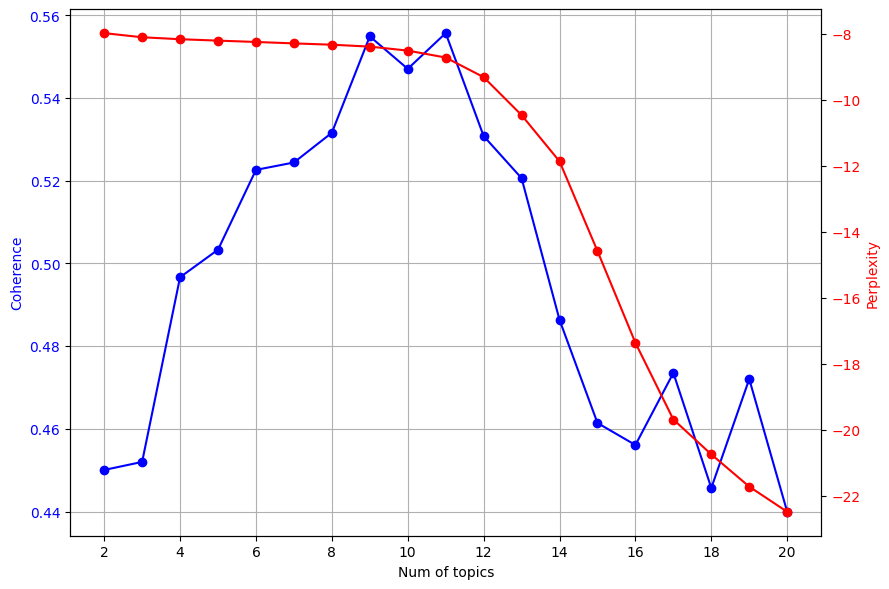

In [134]:
fig, ax1 = plt.subplots(figsize=(9,6))
l = len(coherence)

ax1.set_xlabel("Num of topics")
ax1.set_ylabel("Coherence", c="b")
ax1.plot(range(2, l), coherence[2:], c="b", marker="o")
ax1.tick_params(axis='y', labelcolor="b")
ax1.grid()


ax2 = ax1.twinx()
ax2.set_ylabel("Perplexity", c="r")
ax2.plot(range(2, l), perplexity[2:], c="r", marker="o")
ax2.set_xticks(range(2, l, 2))
ax2.tick_params(axis='y', labelcolor="r")


fig.tight_layout()
plt.show()

In [135]:
opt_n_topics = best_model.num_topics
opt_n_topics

11

In [136]:
print("Coherence:  ", coherence[opt_n_topics].round(5))
print("Perplexity:", perplexity[opt_n_topics].round(5))

Coherence:   0.55567
Perplexity: -8.72516


In [137]:
td = prepare_topic_dist_for_plot(best_model, corpus)
td.shape

(7613, 11)

### Lista tematów i dokumentów najbardziej reprezentujących dany temat

In [138]:
most_repr_docs_for_topics(best_model, td, data)

,Keywords,Text,Topic_pct
Topic,,,
0,"still, war, come, thunder, official",Severe storm weakening as it moves SE towards ...,0.377703
1,"people, year, mosque, https, think",FedEx not willing to transport research specim...,0.412012
2,"wreck, wound, fire, weapon, home",First night with retainers in. It's quite weir...,0.453880
3,"more, family, tornado, good, state",wreck? wreck wreck wreck wreck wreck wreck wre...,0.616403
4,"just, get, car, even, late",Who is bringing the tornadoes and floods. Who ...,0.375311
5,"so, crew, know, need, lol",only had a car for not even a week and got in ...,0.495607
6,"kill, wild, now, see, train",Idgaf who tough or who from Canada and who fro...,0.397812
7,"wreckage, video, new, make, watch",http://t.co/pWwpUm6RBj Twelve feared killed in...,0.493237
8,"go, life, back, part, siren",Refugio oil spill may have been costlier bigge...,0.419733


Poniżej widzimy parametr $\underline{\alpha}$ w rozkładzie Dirichleta $Dir(\underline{\alpha})$ opisującym rozkład tematów w dokumentach.

In [139]:
print(best_model.alpha)

[0.88318133 0.6955964  1.5250664  0.9677309  1.191602   0.7874867
 1.1675245  1.0453781  1.3799962  0.4663766  0.4542952 ]


In [140]:
best_model.show_topics(num_words=6)

[(10,
  '0.081*"pm" + 0.059*"investigator" + 0.049*"evacuate" + 0.041*"day" + 0.026*"nearly" + 0.026*"cause"'),
 (9,
  '0.090*"say" + 0.061*"bomb" + 0.037*"disaster" + 0.032*"man" + 0.030*"warn" + 0.026*"last"'),
 (1,
  '0.043*"people" + 0.040*"year" + 0.039*"mosque" + 0.039*"https" + 0.037*"think" + 0.036*"saudi"'),
 (5,
  '0.091*"so" + 0.027*"crew" + 0.026*"know" + 0.024*"need" + 0.024*"lol" + 0.022*"show"'),
 (0,
  '0.039*"still" + 0.034*"war" + 0.031*"come" + 0.026*"thunder" + 0.025*"official" + 0.024*"nuclear"'),
 (7,
  '0.050*"wreckage" + 0.036*"video" + 0.036*"new" + 0.034*"make" + 0.028*"watch" + 0.026*"fall"'),
 (6,
  '0.064*"kill" + 0.051*"wild" + 0.048*"now" + 0.040*"see" + 0.026*"train" + 0.021*"quarantine"'),
 (4,
  '0.062*"just" + 0.061*"get" + 0.031*"car" + 0.025*"even" + 0.025*"late" + 0.022*"zone"'),
 (8,
  '0.050*"go" + 0.024*"life" + 0.020*"back" + 0.020*"part" + 0.018*"siren" + 0.018*"time"'),
 (2,
  '0.073*"wreck" + 0.054*"wound" + 0.047*"fire" + 0.040*"weapon" + 0

### metryka Geometric Alpha-Coherence
$\underline{\alpha} = [\alpha_1, \ldots, \alpha_k]$ - parametr z rozkładu Dirichleta

$c$ - wskaźnik koherencji (znormalizowany do $(-1, 1)$ lub $(0, 1)$)
$$GAC = \left|\frac{\sqrt[n]{\prod_{i=1}^k \alpha_i}}{c}\right|$$

* Czym mniejszy tym lepiej
* działa dobrze na korpusie, gdzie dokumenty bardzo się od siebie różnią

## n_topics = 3

Utworzymy również model, który podzieli dokumenty między 3 tematy, aby móc to zwizualizować.

In [141]:
lda_model_3 = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,
#     random_state=100,
    update_every=1,
    chunksize=300,
    passes=10,
    alpha="auto"
)

In [142]:
lda_model_3.show_topics(num_words=6)

[(0,
  '0.022*"pm" + 0.017*"so" + 0.017*"investigator" + 0.016*"fire" + 0.015*"suicide" + 0.015*"kill"'),
 (1,
  '0.018*"just" + 0.016*"now" + 0.013*"weapon" + 0.011*"say" + 0.010*"people" + 0.010*"video"'),
 (2,
  '0.036*"wreck" + 0.021*"get" + 0.019*"wreckage" + 0.018*"family" + 0.017*"go" + 0.015*"more"')]

In [143]:
td_3 = prepare_topic_dist_for_plot(lda_model_3, corpus)

In [144]:
get_metrics(lda_model_3, corpus, data_words, id2word)

Coherence:   0.3900455259556539
Perplexity: -7.8681593151275955


(0.3900455259556539, -7.8681593151275955)

In [145]:
most_repr_docs_for_topics(lda_model_3, td_3, data)

,Keywords,Text,Topic_pct
Topic,,,
0,"pm, so, investigator, fire, suicide",wreck? wreck wreck wreck wreck wreck wreck wre...,0.773775
1,"just, now, weapon, say, people",Suicide bomber kills 15 in Saudi security site...,0.718519
2,"wreck, get, wreckage, family, go",A gas thing just exploded and I heard screams ...,0.744056


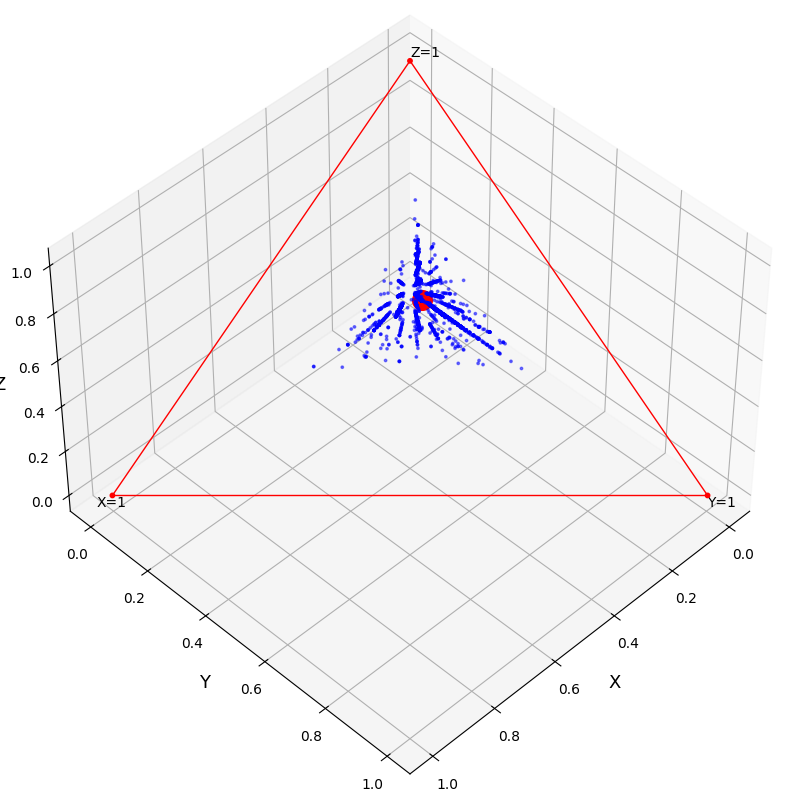

In [146]:
%matplotlib inline    
visualize_3d(td)

### Wizualizujemy próbę z rozkładu Dirichleta z parametrem alfa z modelu

[2.0669396 2.4559302 2.4872854]


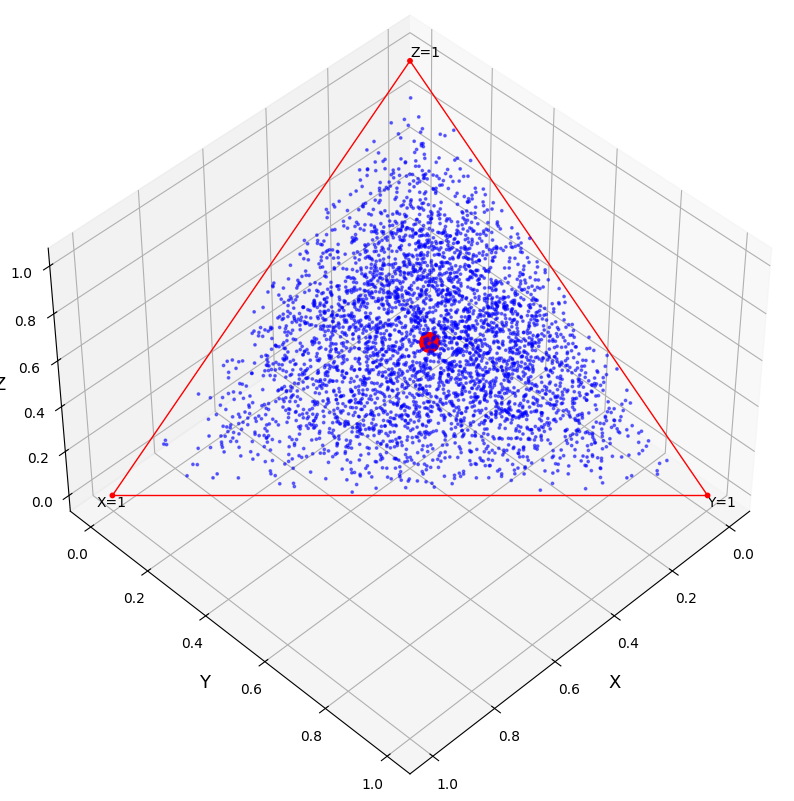

In [147]:
# %matplotlib notebook
print(lda_model_3.alpha)
visualize_3d(sample_Dir3d(lda_model_3.alpha, 4_000))

## For n_topics = 2
Na koniec utworzymy model z 2 tematami, również dla wizualizacji.

In [105]:
lda_model_2 = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=2,
    random_state=10,
    update_every=1,
    chunksize=300,
    passes=10,
    alpha="auto"
)

In [106]:
td_2 = prepare_topic_dist_for_plot(lda_model_2, corpus)
get_metrics(lda_model_2, corpus, data_words, id2word)

Coherence:   0.3593129316423467
Perplexity: -7.782908936056934


(0.3593129316423467, -7.782908936056934)

In [108]:
lda_pred_2 = np.argmax(td_2, axis=1)
target = df_orig.target.to_numpy()
lda_pred_2.mean()

0.887692105608827

In [109]:
if ((target != lda_pred_2)).mean() > 0.5:
    lda_pred_2 = 1 - lda_pred_2

In [110]:
conf_pct = np.divide(confusion_matrix(target, lda_pred_2).T, confusion_matrix(target, lda_pred_2).sum(axis=1)).T
conf_pct

array([[0.95762322, 0.04237678],
       [0.79486396, 0.20513604]])

<Axes: >

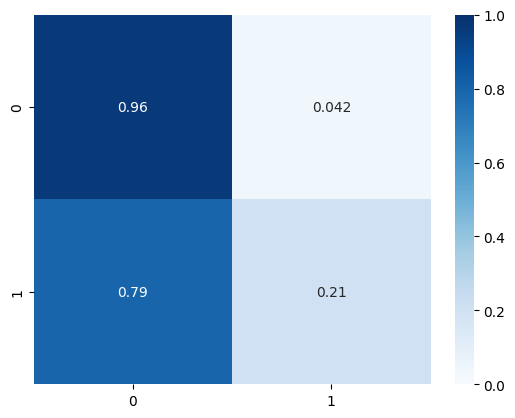

In [114]:
sns.heatmap(conf_pct, cmap="Blues", vmin=0, vmax=1, annot=True)

In [115]:
ind_max = np.argmax(td_2, axis=1).tolist()

In [116]:
maxes = td_2[range(7613), ind_max]

In [117]:
cert_ind = np.where(maxes > 0.6)[0]

In [118]:
lda_pred = np.argmax(td_2, axis=1)[cert_ind]
target = df_orig.target.to_numpy()[cert_ind]
lda_pred.mean()

0.9464007478965409

In [119]:
if ((target != lda_pred)).mean() > 0.5:
    lda_pred = 1 - lda_pred

In [120]:
confusion_matrix(target, lda_pred)

array([[3877,   63],
       [2197,  281]], dtype=int64)

In [121]:
conf_pct = np.divide(confusion_matrix(target, lda_pred).T, confusion_matrix(target, lda_pred).sum(axis=1)).T
conf_pct

array([[0.98401015, 0.01598985],
       [0.8866021 , 0.1133979 ]])

<Axes: >

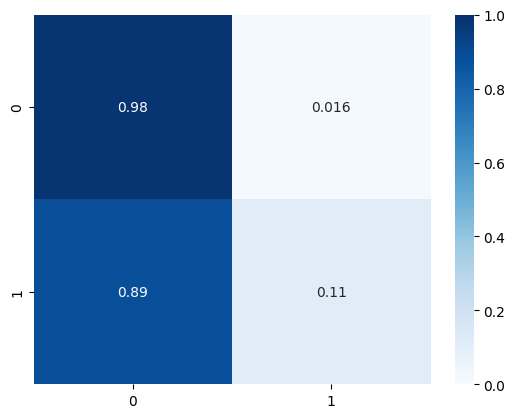

In [123]:
%matplotlib inline
sns.heatmap(conf_pct, cmap="Blues", vmin=0, vmax=1, annot=True)

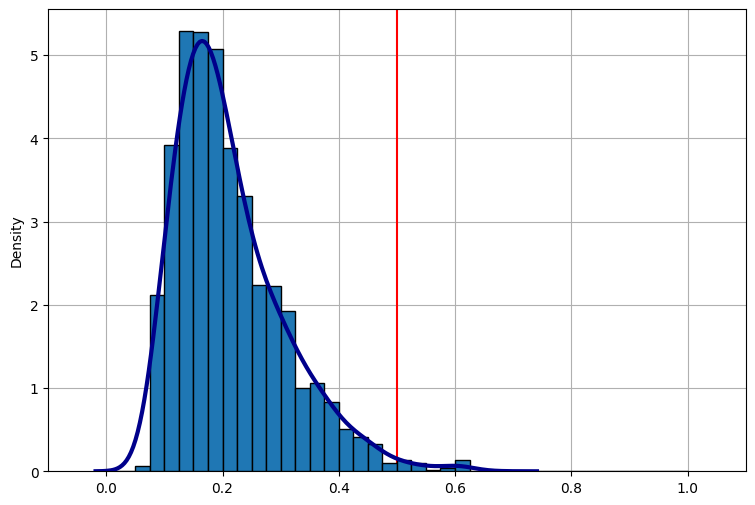

In [125]:
%matplotlib inline
plt.figure(figsize=(9,6))
plt.hist(td[:, 0], bins=np.linspace(0, 1, 41), edgecolor="black", zorder=5, density=True)
sns.kdeplot(td[:, 0], zorder=100, c="darkblue", linewidth=3, bw=0.3)
plt.axvline(0.5, c="r")
plt.xlim(-0.1, 1.1)
plt.grid(zorder=0)
plt.show()

In [126]:
create_save_vis(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.018027  0.261873       1        1  41.114004
1      0.232098 -0.131766       2        1  37.652471
2     -0.214071 -0.130106       3        1  21.233525, topic_info=          Term        Freq       Total Category  logprob  loglift
506      wreck  481.000000  481.000000  Default  20.0000  20.0000
277         pm  235.000000  235.000000  Default  19.0000  19.0000
7853  wreckage  327.000000  327.000000  Default  18.0000  18.0000
19        just  227.000000  227.000000  Default  17.0000  17.0000
51          so  182.000000  182.000000  Default  16.0000  16.0000
...        ...         ...         ...      ...      ...      ...
1964      wind   32.380266   32.958559   Topic3  -5.5347   1.5319
140       head   38.869118   39.566246   Topic3  -5.3520   1.5318
2272      sink   87.425911   90.384504   Topic3  -4.5414   1.5163
51          so  172.305311  182.622339   Topic3  -3.8630   1.4914
19        just  196.649987  227.629778   Topic3  -3.7308   1.4033

[98 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
979        3  0.992688     again
1081       1  0.995943    attack
321        1  0.997741      back
1303       1  0.995040      bomb
10108      1  0.983772    bomber
...      ...       ...       ...
506        3  0.002076     wreck
7853       1  0.009163  wreckage
7853       2  0.983465  wreckage
7853       3  0.006108  wreckage
177        1  0.992497      year

[104 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])